# Assignment 7

In [36]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

### Set up connection to WRDS...

In [246]:
#sign in

import wrds
db=wrds.Connection(wrds_username='sevogel')
#db.create_pgpass_file()


Loading library list...
Done


### Download and format data

In [247]:
import numpy as np
import datetime
import pandas as pd
import datetime
#################################
# Get data
#################################

# get risk-free rate see http://www.crsp.com/files/treasury_guide_0.pdf
Rf=db.raw_sql("select  mcaldt,tmytm "
           "from crsp.tfz_mth_rf "           
            "where kytreasnox = 2000001 "
           "and mcaldt>='2000-01-01'"
            "and mcaldt<='2019-12-31'", date_cols=['mcaldt'])

#transform annualized and continuously compounded returns into simple and monthly returns:
Rf['tmytm']=np.exp(Rf['tmytm']/12/100)-1
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})

#use own index instead
# get index returns
data_index=db.raw_sql("select  date,vwretd "
           "from crsp.msi "
           "where date>='2000-01-01'"
            "and date<='2019-12-31'", date_cols=['date'])


# get stock returns
crsp_m = db.raw_sql("""
                      select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/2000' and '12/31/2019'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 
msf=crsp_m.drop(['shrcd','exchcd'],axis=1)
del(crsp_m) 

msf['prc']=np.abs(msf['prc'])

###################### taking care of delistings ########################
#########################################################################

## get data on delisting returns

#mse_data = db.raw_sql("""SELECT date, permno, dlret 
#           FROM crsp.mseall
#           WHERE date between '01/01/1970' and '12/31/2018'""", date_cols=['date'])

##check for duplicates
#mse_data = mse_data[~mse_data.duplicated()].copy()
#print('duplicates in data on dlret?')
#print(mse_data.duplicated(subset=['date','permno']).sum(),'\n')

#merge with original dataset

#msf =pd.merge(msf, mse_data, how='left', left_on=['permno','date'],right_on=['permno','date'])

#del(mse_data) 


## Returns adjusted for delisting
#msf['retadj'] = ((1+data['ret'].fillna(0))*(1+msf['dlret'].fillna(0))-1)
#msf.loc[msf[['ret', 'dlret']].isnull().all(axis=1), 'retadj'] = np.nan
#msf['ret']=msf['retadj']

#msf=msf.drop(['dlret','retadj'],axis=1)

######################### continue normally #############################
#########################################################################

#################################
# Define some stuff...
#################################

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

#variables
msf['permno'] = msf['permno'].astype(int)
msf['size'] = msf['shrout'] * msf['prc'].abs()
msf['const'] = 1
msf.sort_values(['permno','date'])

msf['size_lag']= msf.groupby('permno')['size'].shift(1).to_frame()

obs=msf[['const','permno']].groupby(['permno']).sum().reset_index().rename(columns={'const': 'obs'})
msf = pd.merge(msf, obs, how='left', left_on=['permno'],right_on=['permno'])



#################################
# Compute excess returns
#################################
data_index = pd.merge(data_index, Rf, how='left', left_on=['date'],right_on='date')
data_index['mprem']=(data_index['vwretd']-data_index['rf'])
data = pd.merge(msf, data_index, how='left', left_on=['date'],right_on='date')
data['exret']=data['ret']-data['rf']





print('duplicates in data on returns?')
print(data.duplicated(subset=['date','permno']).sum(),'\n')

print(' How many obervations do we have in a month?')
print('max:', max(data[['date','const']].groupby('date').sum()['const'].values))
print('min:', min(data[['date','const']].groupby('date').sum()['const'].values))

print('\n How often do we observe a given stock?')
print('max:', max(data['obs'].values))
print('min:', min(data['obs'].values))

print('\n Let us limit our attention to stocks we observe often enough...')



duplicates in data on returns?
0 

 How many obervations do we have in a month?
max: 2310
min: 1403

 How often do we observe a given stock?
max: 240
min: 1

 Let us limit our attention to stocks we observe often enough...


In [248]:
# save data
data.to_csv('data1.csv', sep=';', index=False)
data_index.to_csv('data1_index.csv', sep=';', index=False)
Rf.to_csv('Rf1.csv', sep=';', index=False)

In case memory crashes, take a break here and load only the necessary data below...

### Calculate betas for the whole sample period, get portfolio returns

 How many obervations do we have now in a year?
max: 636
min: 636

 How often do we observe a given stock now?
max: 240
min: 240

 (a) betas and returns: whole sample and equally-weighted returns:


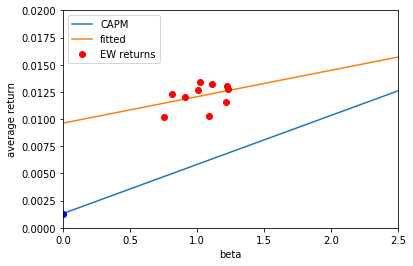

The market risk premium is  0.00451 .

The actual slope is  0.00243 .



,mean exret,alpha,t-stat alpha,CAPM beta,t-stat beta
1,0.008926,0.003998,1.593058,1.092669,14.741888
2,0.010245,0.004751,2.058244,1.218221,17.701719
3,0.011704,0.006183,2.591940,1.224180,14.604769
4,0.011470,0.005916,2.638764,1.231451,17.384971
5,0.011328,0.006797,3.873884,1.004511,18.460381
6,0.011896,0.006868,3.737821,1.115055,19.633105
7,0.012094,0.007470,4.761889,1.025250,19.701049
8,0.010758,0.006656,4.520736,0.909454,17.727005
9,0.011035,0.007354,5.115740,0.816186,16.754307
10,0.008919,0.005526,4.146634,0.752247,19.257041



 (a) betas and returns: whole sample and equally-weighted returns:


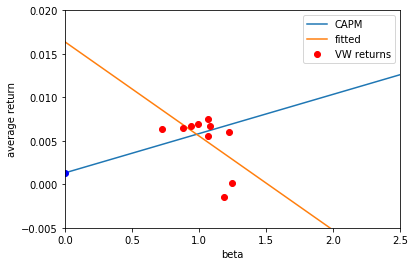

The market risk premium is  0.00451 .

The actual slope is  -0.01081 .



,mean exret,alpha,t-stat alpha,CAPM beta,t-stat beta
1,-0.002790,-0.008161,-2.591925,1.190815,13.519992
2,-0.001195,-0.006808,-2.787442,1.244496,19.347229
3,0.004283,-0.000545,-0.242495,1.070296,18.438393
4,0.004724,-0.000790,-0.322849,1.222725,16.329640
5,0.005395,0.001139,0.639440,0.943720,17.462945
6,0.005410,0.000527,0.333781,1.082758,23.531001
7,0.006202,0.001393,0.833838,1.066274,19.955929
8,0.005647,0.001153,0.948940,0.996494,24.364647
9,0.005201,0.001232,1.148205,0.879929,27.090989
10,0.005090,0.001819,1.485277,0.725307,21.046277


In [9]:
import numpy as np
import pandas as pd

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan
    
# load data
data = pd.read_csv("data1.csv", sep=';')
data=data.drop(['obs'],axis=1)
data = data[data['ret'].notnull()]
obs=data[['const','permno']].groupby(['permno']).sum().reset_index().rename(columns={'const': 'obs'})
data = pd.merge(data, obs, how='left', left_on=['permno'],right_on=['permno'])
data=data[data['obs']==240]

data['date']=pd.to_datetime(data['date'], format='%Y-%m-%d')

data_index = pd.read_csv("data1_index.csv", sep=';')
data_index['date']=pd.to_datetime(data_index['date'], format='%Y-%m-%d')

Rf = pd.read_csv("Rf1.csv", sep=';')
Rf['date']=pd.to_datetime(Rf['date'], format='%Y-%m-%d')
# If price data is used, one needs to use the absolute values (some observations are negative)

data['prc']=np.abs(data['prc'])



#data = data[(data['ret'].notnull()) & (data['size_lag'].notnull())]

print(' How many obervations do we have now in a year?')
print('max:', max(data[['date','const']].groupby('date').sum()['const'].values))
print('min:', min(data[['date','const']].groupby('date').sum()['const'].values))

print('\n How often do we observe a given stock now?')
print('max:', max(data['obs'].values))
print('min:', min(data['obs'].values))


#drop some stuff that is not needed anymore
#data=data.drop(['size','shrout','prc'],axis=1)

#################################
# Compute betas
#################################

############ for the whole sample #############################
covariances=data.groupby('permno')['exret'].cov(data['mprem']).to_frame().reset_index().rename(columns={'exret': 'covar'})
mvar=data.groupby('permno')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})

#merge new values with original dataset
data = pd.merge(data, covariances, how='left', left_on=['permno'],right_on='permno')
data = pd.merge(data, mvar, how='left', left_on=['permno'],right_on='permno')

# cumpute the betas
data['beta']=data['covar']/data['varm']

#drop some stuff that is not needed anymore
data=data.drop(['covar','vwretd', 'varm'],axis=1)

size=data[data['date']=='2019-12-31'][['permno','size']]
size=size.rename(columns={'size': 'size_end'})

#merge new values with original dataset
data = pd.merge(data, size, how='left', left_on=['permno'],right_on='permno')


#################################
# Compute deciles
#################################

data['decile']=1+data[['size_end','date']].groupby('date')\
.transform(lambda x: pd.qcut(x, 10, labels=False))


data = data.sort_values(['decile', 'date'])



#################################
# Compute Equally Weighted Returns and Betas #
#################################

# in order to keep track of the dates, it is convenient to define an index
data=data.set_index('date')  

# equally weigthed return
ewrets=data.groupby(['decile','date']).apply(wavg, 'ret','const')\
.to_frame().reset_index().rename(columns={0: 'ewret'})

ewbetas=data.groupby(['decile']).apply(wavg, 'beta','const')\
.to_frame().reset_index().rename(columns={0: 'beta'})

ewsize=data.groupby(['decile']).apply(wavg, 'size_end','const')\
.to_frame().reset_index().rename(columns={0: 'size'})




#avgewrets=ewrets.groupby(['decile']).apply(wavg, 'ewret','const')\
#.to_frame().reset_index().rename(columns={0: 'ewret_avg'})
avgewrets=ewrets.groupby(['decile']).mean().reset_index()

# convert data back to what we had before
data=data.reset_index()
#################################
# Compute value-weighted Returns and Betas #
#################################

# in order to keep track of the dates, it is convenient to define an index
data=data.set_index('date')  

# value weigthed return
vwrets=data.groupby(['decile','date']).apply(wavg, 'ret','size_lag')\
.to_frame().reset_index().rename(columns={0: 'vwret'})

##########
###########
############
vwdata=pd.merge(vwrets, Rf, how='left', left_on=['date'],right_on='date')
vwdata=pd.merge(vwrets, data_index, how='left', left_on=['date'],right_on='date')
vwdata['vwexret']=vwdata['vwret']-vwdata['rf']
covariances=vwdata.groupby('decile')['vwexret'].cov(vwdata['mprem']).to_frame().reset_index().rename(columns={'vwexret': 'covar'})
mvar=vwdata.groupby('decile')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})

#merge stuff
vwbetas = pd.merge(covariances, mvar, how='left', left_on=['decile'],right_on='decile')
# cumpute the betas
vwbetas['beta']=vwbetas['covar']/vwbetas['varm']
#drop some stuff that is not needed anymore
vwbetas=vwbetas.drop(['covar', 'varm'],axis=1)



avgvwrets=vwrets.groupby(['decile']).mean().reset_index()

# convert data back to what we had before
data=data.reset_index()

#################################
# Fama-McBeth #
#################################
import statsmodels.formula.api as sm

regdata = pd.merge(avgewrets, ewbetas, how='left', left_on=['decile'],right_on='decile')

result1 = sm.ols(formula="ewret ~ beta", data=regdata).fit()

regdata = pd.merge(avgvwrets, vwbetas, how='left', left_on=['decile'],right_on='decile')

result2 = sm.ols(formula="vwret ~ beta", data=regdata).fit()


#make plots of returns vs. beta
import matplotlib.pyplot as plt
R0=Rf[Rf['date']>'1979-01-31']['rf'].mean()
MP=data_index[data_index['date']>'1979-01-31']['mprem'].values.mean()

beta_values = np.linspace(0,2.5,100)



# first plot
CAPM_line = R0+MP*beta_values
fitted_line=result1.params.values[0]+result1.params.values[1]*beta_values


plt.plot(beta_values,CAPM_line)
plt.plot(beta_values,fitted_line)

plt.plot(ewbetas['beta'].values,avgewrets['ewret'].values,'ro')
plt.plot(0,R0,'bo')
plt.xlabel('beta')
plt.ylabel('average return')
plt.xlim(0, 2.5)
plt.ylim(0, 0.02)
plt.legend(['CAPM','fitted','EW returns'], loc=0)
print('\n (a) betas and returns: whole sample and equally-weighted returns:')

plt.savefig('FS_VW_plot.png', format='png')
plt.show()
print('The market risk premium is ',np.round(MP,5) ,'.\n')
print('The actual slope is ',np.round(result1.params.values[1],5),'.\n')

import statsmodels.regression.linear_model as lm

lab_columns = ['mean exret','alpha','t-stat alpha', 'CAPM beta','t-stat beta']
lab_ind_tmp = np.array(range(1,11))


df_data_ew = pd.DataFrame(data=np.empty((10, 5)), columns=lab_columns,index=lab_ind_tmp)


for i in range(1,11): 

    # model specification
    y = ewrets[ewrets['decile']==i]['ewret'].values-Rf['rf'].values
    x = data_index['mprem'].values
    X = lm.add_constant(x)

    model = lm.OLS(endog=y,exog=X,missing='drop')
    results = model.fit()
    
    # update table
    #df_data.loc[i].iloc[0:4] = np.concatenate((results.params,results.params))
    df_data_ew.loc[i].iloc[0:5] = [ewrets[ewrets['decile']==i]['ewret'].mean()-R0,results.params[0],np.divide(results.params[0],results.HC0_se[0]),results.params[1],np.divide(results.params[1],results.HC0_se[1])]


display(df_data_ew)


# second plot: value weighting
CAPM_line = R0+MP*beta_values
fitted_line=result2.params.values[0]+result2.params.values[1]*beta_values


plt.plot(beta_values,CAPM_line)
plt.plot(beta_values,fitted_line)

plt.plot(vwbetas['beta'].values,avgvwrets['vwret'].values,'ro')
plt.plot(0,R0,'bo')
plt.xlabel('beta')
plt.ylabel('average return')
plt.xlim(0, 2.5)
plt.ylim(-0.005, 0.02)
plt.legend(['CAPM','fitted','VW returns'], loc=0)
print('\n (a) betas and returns: whole sample and equally-weighted returns:')

plt.savefig('FS_VW_plot.png', format='png')

plt.show()
print('The market risk premium is ',np.round(MP,5) ,'.\n')
print('The actual slope is ',np.round(result2.params.values[1],5),'.\n')

import statsmodels.regression.linear_model as lm

lab_columns = ['mean exret','alpha','t-stat alpha', 'CAPM beta','t-stat beta']
lab_ind_tmp = np.array(range(1,11))


df_data = pd.DataFrame(data=np.empty((10, 5)), columns=lab_columns,index=lab_ind_tmp)


import statsmodels.regression.linear_model as lm

lab_columns = ['mean exret','alpha','t-stat alpha', 'CAPM beta','t-stat beta']
lab_ind_tmp = np.array(range(1,11))


df_data_vw = pd.DataFrame(data=np.empty((10, 5)), columns=lab_columns,index=lab_ind_tmp)


for i in range(1,11): 

    # model specification
    y = vwrets[vwrets['decile']==i]['vwret'].values-Rf['rf'].values
    x = data_index['mprem'].values
    X = lm.add_constant(x)

    model = lm.OLS(endog=y,exog=X,missing='drop')
    results = model.fit()
    
    # update table
    #df_data.loc[i].iloc[0:4] = np.concatenate((results.params,results.params))
    df_data_vw.loc[i].iloc[0:5] = [vwrets[vwrets['decile']==i]['vwret'].mean()-R0,results.params[0],np.divide(results.params[0],results.HC0_se[0]),results.params[1],np.divide(results.params[1],results.HC0_se[1])]

display(df_data_vw)


Alphas for equally weighted returns are all positive. This can be explained by the fact that equal-weighted returns are returns of a dynamic trading strategy: in order to achieve those returns, monthly rebalancing is necessary.

For value-weighted returns, alphas are closer to zero (on average). The negative slope of the fitted line seems to be driven by tow outliers (the stocks of the firms with the smallest market capitalization in the end of the sample. For the other firms, the relationship between betas and expected returns seems flat.

# dynamic trading


 (a) betas and returns: whole sample and equally-weighted returns:


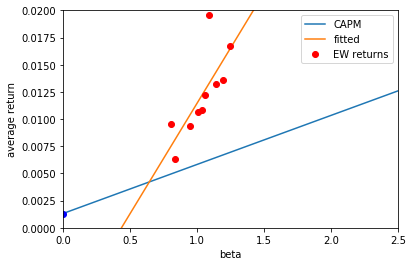

The market risk premium is  0.00451 .

The actual slope is  0.0203 .



,mean exret,alpha,t-stat alpha,CAPM beta,t-stat beta
1,0.018303,0.013374,4.699956,1.092827,12.173174
2,0.015371,0.009763,3.222116,1.243510,12.969800
3,0.012308,0.006922,2.706513,1.194197,14.164243
4,0.011881,0.006717,3.040497,1.144814,15.810513
5,0.010912,0.006115,3.153623,1.063432,18.926754
6,0.009494,0.004810,2.973781,1.038504,20.808212
7,0.009310,0.004772,2.990012,1.006144,19.089640
8,0.008022,0.003751,2.431735,0.946992,17.798991
9,0.008217,0.004583,3.399351,0.805624,18.165961
10,0.004978,0.001225,1.167645,0.832109,27.511471



 (a) betas and returns: whole sample and equally-weighted returns:


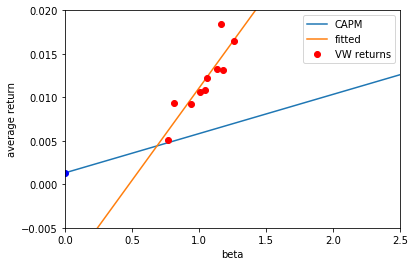

The market risk premium is  0.00451 .

The actual slope is  0.02121 .



,mean exret,alpha,t-stat alpha,CAPM beta,t-stat beta
1,0.017092,0.011829,4.072685,1.166957,11.713940
2,0.015144,0.009468,3.133709,1.258599,13.040560
3,0.011786,0.006458,2.566673,1.181344,14.426120
4,0.011917,0.006804,3.108388,1.133866,15.938680
5,0.010952,0.006159,3.179888,1.062742,18.900707
6,0.009544,0.004826,2.971910,1.045912,20.523333
7,0.009246,0.004689,2.925672,1.010382,19.041045
8,0.007927,0.003683,2.356378,0.940906,17.127275
9,0.008006,0.004330,3.224913,0.814967,18.456893
10,0.003775,0.000319,0.298272,0.766275,25.592539


In [11]:


# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan
    
# load data
data = pd.read_csv("data1.csv", sep=';')
data=data.drop(['obs'],axis=1)
data = data[data['ret'].notnull()]
obs=data[['const','permno']].groupby(['permno']).sum().reset_index().rename(columns={'const': 'obs'})
data = pd.merge(data, obs, how='left', left_on=['permno'],right_on=['permno'])
data=data[data['obs']==240]

data['date']=pd.to_datetime(data['date'], format='%Y-%m-%d')

data_index = pd.read_csv("data1_index.csv", sep=';')
data_index['date']=pd.to_datetime(data_index['date'], format='%Y-%m-%d')

Rf = pd.read_csv("Rf1.csv", sep=';')
Rf['date']=pd.to_datetime(Rf['date'], format='%Y-%m-%d')
# If price data is used, one needs to use the absolute values (some observations are negative)

data['prc']=np.abs(data['prc'])
#data=data[data.obs>5]
data=data[data.obs==240]


#################################
# Compute deciles
#################################

data['decile']=1+data[['size_lag','date']].groupby('date')\
.transform(lambda x: pd.qcut(x, 10, labels=False))


data = data.sort_values(['decile', 'date'])



#################################
# Compute Equally Weighted Returns and Betas #
#################################

# in order to keep track of the dates, it is convenient to define an index
data=data.set_index('date')  

# equally weigthed return
ewrets=data.groupby(['decile','date']).apply(wavg, 'ret','const')\
.to_frame().reset_index().rename(columns={0: 'ewret'})

ewdata=pd.merge(ewrets, Rf, how='left', left_on=['date'],right_on='date')
ewdata=pd.merge(ewrets, data_index, how='left', left_on=['date'],right_on='date')
ewdata['ewexret']=ewdata['ewret']-ewdata['rf']
covariances=ewdata.groupby('decile')['ewexret'].cov(ewdata['mprem']).to_frame().reset_index().rename(columns={'ewexret': 'covar'})
mvar=ewdata.groupby('decile')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})

#merge stuff
ewbetas = pd.merge(covariances, mvar, how='left', left_on=['decile'],right_on='decile')
# cumpute the betas
ewbetas['beta']=ewbetas['covar']/ewbetas['varm']
#drop some stuff that is not needed anymore
ewbetas=ewbetas.drop(['covar', 'varm'],axis=1)


#avgewrets=ewrets.groupby(['decile']).apply(wavg, 'ewret','const')\
#.to_frame().reset_index().rename(columns={0: 'ewret_avg'})
avgewrets=ewrets.groupby(['decile']).mean().reset_index()

# convert data back to what we had before
data=data.reset_index()

#################################
# Compute value-weighted Returns and Betas #
#################################

# in order to keep track of the dates, it is convenient to define an index
data=data.set_index('date')  

# equally weigthed return
vwrets=data.groupby(['decile','date']).apply(wavg, 'ret','size_lag')\
.to_frame().reset_index().rename(columns={0: 'vwret'})

##########

vwdata=pd.merge(vwrets, Rf, how='left', left_on=['date'],right_on='date')
vwdata=pd.merge(vwrets, data_index, how='left', left_on=['date'],right_on='date')
vwdata['vwexret']=vwdata['vwret']-vwdata['rf']
covariances=vwdata.groupby('decile')['vwexret'].cov(vwdata['mprem']).to_frame().reset_index().rename(columns={'vwexret': 'covar'})
mvar=vwdata.groupby('decile')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})

#merge stuff
vwbetas = pd.merge(covariances, mvar, how='left', left_on=['decile'],right_on='decile')
# cumpute the betas
vwbetas['beta']=vwbetas['covar']/vwbetas['varm']
#drop some stuff that is not needed anymore
vwbetas=vwbetas.drop(['covar', 'varm'],axis=1)



avgvwrets=vwrets.groupby(['decile']).mean().reset_index()

# convert data back to what we had before
data=data.reset_index()

#################################
# Fama-McBeth #
#################################
import statsmodels.formula.api as sm

regdata = pd.merge(avgewrets, ewbetas, how='left', left_on=['decile'],right_on='decile')

result1 = sm.ols(formula="ewret ~ beta", data=regdata).fit()

regdata = pd.merge(avgvwrets, vwbetas, how='left', left_on=['decile'],right_on='decile')

result2 = sm.ols(formula="vwret ~ beta", data=regdata).fit()


#make plots of returns vs. beta
import matplotlib.pyplot as plt
R0=Rf[Rf['date']>'1979-01-31']['rf'].mean()
MP=data_index[data_index['date']>'1979-01-31']['mprem'].values.mean()

beta_values = np.linspace(0,2.5,100)



# first plot
CAPM_line = R0+MP*beta_values
fitted_line=result1.params.values[0]+result1.params.values[1]*beta_values


plt.plot(beta_values,CAPM_line)
plt.plot(beta_values,fitted_line)

plt.plot(ewbetas['beta'].values,avgewrets['ewret'].values,'ro')
plt.plot(0,R0,'bo')
plt.xlabel('beta')
plt.ylabel('average return')
plt.xlim(0, 2.5)
plt.ylim(0, 0.02)
plt.legend(['CAPM','fitted','EW returns'], loc=0)
print('\n (a) betas and returns: whole sample and equally-weighted returns:')

plt.savefig('rolling_VW_plot.png', format='png')
plt.show()
print('The market risk premium is ',np.round(MP,5) ,'.\n')
print('The actual slope is ',np.round(result1.params.values[1],5),'.\n')

import statsmodels.regression.linear_model as lm

lab_columns = ['mean exret','alpha','t-stat alpha', 'CAPM beta','t-stat beta']
lab_ind_tmp = np.array(range(1,11))


df_data = pd.DataFrame(data=np.empty((10, 5)), columns=lab_columns,index=lab_ind_tmp)


for i in range(1,11): 

    # model specification
    y = ewrets[ewrets['decile']==i]['ewret'].values-Rf['rf'].values
    x = data_index['mprem'].values
    X = lm.add_constant(x)

    model = lm.OLS(endog=y,exog=X,missing='drop')
    results = model.fit()
    
    # update table
    #df_data.loc[i].iloc[0:4] = np.concatenate((results.params,results.params))
    df_data.loc[i].iloc[0:5] = [ewrets[ewrets['decile']==i]['ewret'].mean()-R0,results.params[0],np.divide(results.params[0],results.HC0_se[0]),results.params[1],np.divide(results.params[1],results.HC0_se[1])]



display(df_data)

# second plot: value weighting
CAPM_line = R0+MP*beta_values
fitted_line=result2.params.values[0]+result2.params.values[1]*beta_values


plt.plot(beta_values,CAPM_line)
plt.plot(beta_values,fitted_line)

plt.plot(vwbetas['beta'].values,avgvwrets['vwret'].values,'ro')
plt.plot(0,R0,'bo')
plt.xlabel('beta')
plt.ylabel('average return')
plt.xlim(0, 2.5)
plt.ylim(-0.005, 0.02)
plt.legend(['CAPM','fitted','VW returns'], loc=0)
print('\n (a) betas and returns: whole sample and equally-weighted returns:')

plt.savefig('rolling_VW_plot.png', format='png')

plt.show()
print('The market risk premium is ',np.round(MP,5) ,'.\n')
print('The actual slope is ',np.round(result2.params.values[1],5),'.\n')

import statsmodels.regression.linear_model as lm

lab_columns = ['mean exret','alpha','t-stat alpha', 'CAPM beta','t-stat beta']
lab_ind_tmp = np.array(range(1,11))


df_data = pd.DataFrame(data=np.empty((10, 5)), columns=lab_columns,index=lab_ind_tmp)


import statsmodels.regression.linear_model as lm

lab_columns = ['mean exret','alpha','t-stat alpha', 'CAPM beta','t-stat beta']
lab_ind_tmp = np.array(range(1,11))


df_data = pd.DataFrame(data=np.empty((10, 5)), columns=lab_columns,index=lab_ind_tmp)


for i in range(1,11): 

    # model specification
    y = vwrets[vwrets['decile']==i]['vwret'].values-Rf['rf'].values
    x = data_index['mprem'].values
    X = lm.add_constant(x)

    model = lm.OLS(endog=y,exog=X,missing='drop')
    results = model.fit()
    
    # update table
    #df_data.loc[i].iloc[0:4] = np.concatenate((results.params,results.params))
    df_data.loc[i].iloc[0:5] = [vwrets[vwrets['decile']==i]['vwret'].mean()-R0,results.params[0],np.divide(results.params[0],results.HC0_se[0]),results.params[1],np.divide(results.params[1],results.HC0_se[1])]

    
display(df_data)